## Convert all weather data to the same resolution and save for the different subareas


In [1]:
# import all necessary libraries
import os
from datetime import datetime, timedelta
import getpass
import xarray as xr
!python -m pip install motuclient==1.8.4 --no-cache-dir
import motuclient
import xarray as xr
import numpy as np
!python -m pip install ffmpeg==1.4
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import pandas as pd
!python -m pip install rioxarray
import rioxarray
import rasterio as rio
import rasterio.plot
!python -m pip install netCDF4
import netCDF4
!python -m pip install h5netcdf
import h5netcdf
import random
from skimage import io as skio
import ffmpeg
import matplotlib.gridspec as gridspec
import subprocess
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from numba import jit, cuda
import tifffile
from tqdm import tqdm
import skimage.transform as sktransform
import tensorflow as tf
!pip install dask==2022.12.1
import dask
from dask.graph_manipulation import bind, wait_on

  Preparing metadata (setup.py) ... done
  Created wheel for motuclient: filename=motuclient-1.8.4-py3-none-any.whl size=32873 sha256=b0e9f5670309b50d213879e4677c5e419004f20415813f1fffa140a730b4f27d
  Stored in directory: /tmp/pip-ephem-wheel-cache-iwuijf_x/wheels/46/74/d1/ee3216f52d83212f10a0a5f5b94f3d99cf3d29b8ecf09c60b6
Successfully built motuclient
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=c25977890f28363567985f20f1d65533cfe6cf049c46912aa77b628e1b977458
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
chl_dir = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km'
mask_dir = r'/content/drive/MyDrive/MasterThesis/Data/land_mask/iowtopo2_rev03.nc'
wind_dir = r'/content/drive/MyDrive/MasterThesis/Data/Prescipitation'
pres_dir = r'/content/drive/MyDrive/MasterThesis/Data/Prescipitation'
rad_dir = r'/content/drive/MyDrive/MasterThesis/Data/Prescipitation'

data_dir_RIGA = r'/content/drive/MyDrive/MasterThesis/Data_preprocessing/GulfofRiga'
data_dir_KTT = r'/content/drive/MyDrive/MasterThesis/Data_preprocessing/Kattegat'
data_dir_GTL = r'/content/drive/MyDrive/MasterThesis/Data_preprocessing/Gotland'

data_dir = r'/content/drive/MyDrive/MasterThesis/Predictions/Data'

In [4]:
riga_range_x  = range(720,880,1)
riga_range_y = range(330,490,1)

kattegat_range_x  = range(50,210,1)
kattegat_range_y = range(200,360,1)

gotland_range_x  = range(470,630,1)
gotland_range_y = range(160,320,1)

# climate_data_pred.nc

## CHL data

In [6]:
chl_data = xr.open_mfdataset(f"{chl_dir}/CHL_data_"+"*2021.nc", decode_coords="all")
chl_data = chl_data.sel(time=~chl_data.get_index("time").duplicated())
chl_data = chl_data.rename_dims({'lon': 'x', 'lat': 'y'}).rename_vars({"lon": "x", "lat": "y"}).set_coords(["x", "y"])

## Prediction Data

In [12]:
wind_data = xr.open_dataset(f"{data_dir}/climate_data_pred.nc") #, drop_variables='v10'
wind_data = wind_data.resample(time='1D').mean('time').compute()
wind_data

<xarray.Dataset>
Dimensions:    (longitude: 85, latitude: 51, expver: 2, time: 54)
Coordinates:
  * longitude  (longitude) float32 9.25 9.5 9.75 10.0 ... 29.5 29.75 30.0 30.25
  * latitude   (latitude) float32 65.75 65.5 65.25 65.0 ... 53.75 53.5 53.25
  * expver     (expver) int32 5 1
  * time       (time) datetime64[ns] 2023-05-01 2023-05-02 ... 2023-06-23
Data variables:
    u10        (time, expver, latitude, longitude) float32 5.04 4.875 ... nan
    v10        (time, expver, latitude, longitude) float32 2.701 3.173 ... nan
    t2m        (time, expver, latitude, longitude) float32 277.6 277.6 ... nan
    cdir       (time, expver, latitude, longitude) float32 1.001e+06 ... nan
    tp         (time, expver, latitude, longitude) float32 8.343e-05 ... nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-29 17:55:34 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [13]:
wind_data = wind_data.sel(time=~wind_data.get_index("time").duplicated()).compute()
wind_data = wind_data.rename_dims({'longitude': 'x', 'latitude': 'y'}).rename_vars({"longitude": "x", "latitude": "y"}).set_coords(["x", "y"])

In [14]:
time_length = wind_data.u10.shape[0]
print(time_length)
lat_lon_subset = chl_data[['x', 'y']]

54


In [15]:
u10_total_RIGA = np.empty((5,20,160,160))
u10_total_KTT = np.empty((5,20,160,160))
u10_total_GTL = np.empty((5,20,160,160))

v10_total_RIGA = np.empty((5,20,160,160))
v10_total_KTT = np.empty((5,20,160,160))
v10_total_GTL = np.empty((5,20,160,160))

t2m_total_RIGA = np.empty((5,20,160,160))
t2m_total_KTT = np.empty((5,20,160,160))
t2m_total_GTL = np.empty((5,20,160,160))

tp_total_RIGA = np.empty((5,20,160,160))
tp_total_KTT = np.empty((5,20,160,160))
tp_total_GTL = np.empty((5,20,160,160))

cdir_total_RIGA = np.empty((5,20,160,160))
cdir_total_KTT = np.empty((5,20,160,160))
cdir_total_GTL = np.empty((5,20,160,160))

def expand_arrays(expected_times, j):
  print(expected_times[0])
  wind_data_temp= wind_data.sel(time=slice(str(expected_times[0]), str(expected_times[-1])))

  u10_RIGA = np.empty((0,160,160))
  u10_GTL = np.empty((0,160,160))
  u10_KTT = np.empty((0,160,160))
  v10_RIGA = np.empty((0,160,160))
  v10_GTL = np.empty((0,160,160))
  v10_KTT = np.empty((0,160,160))

  t2m_RIGA = np.empty((0,160,160))
  t2m_GTL = np.empty((0,160,160))
  t2m_KTT = np.empty((0,160,160))

  tp_RIGA = np.empty((0,160,160))
  tp_GTL = np.empty((0,160,160))
  tp_KTT = np.empty((0,160,160))

  cdir_RIGA = np.empty((0,160,160))
  cdir_GTL = np.empty((0,160,160))
  cdir_KTT = np.empty((0,160,160))

  print(u10_RIGA.shape)

  time_length = wind_data_temp.u10.shape[0]

  for i in range(time_length):
      wind_data1 = wind_data.isel(time=i)
      wind_data_resampled = wind_data1.interp_like(lat_lon_subset, method='linear').compute()

      wind_data_RIGA = wind_data_resampled.isel(x=riga_range_x, y= riga_range_y)
      wind_data_u_RIGA = wind_data_RIGA['u10'].values
      wind_data_v_RIGA = wind_data_RIGA['v10'].values
      wind_data_tp_RIGA = wind_data_RIGA['tp'].values
      wind_data_t2m_RIGA = wind_data_RIGA['t2m'].values
      wind_data_cdir_RIGA = wind_data_RIGA['cdir'].values


      wind_data_KTT = wind_data_resampled.isel(x=kattegat_range_x, y= kattegat_range_y)
      wind_data_u_KTT = wind_data_KTT['u10'].values
      wind_data_v_KTT = wind_data_KTT['v10'].values
      wind_data_tp_KTT = wind_data_KTT['tp'].values
      wind_data_t2m_KTT = wind_data_KTT['t2m'].values
      wind_data_cdir_KTT = wind_data_KTT['cdir'].values

      wind_data_GTL = wind_data_resampled.isel(x=gotland_range_x, y= gotland_range_y)
      wind_data_u_GTL = wind_data_GTL['u10'].values
      wind_data_v_GTL = wind_data_GTL['v10'].values
      wind_data_tp_GTL = wind_data_GTL['tp'].values
      wind_data_t2m_GTL = wind_data_GTL['t2m'].values
      wind_data_cdir_GTL = wind_data_GTL['cdir'].values

      if np.isnan(wind_data_u_RIGA[0,:,:]).all():
          u10_RIGA = np.append(u10_RIGA, wind_data_u_RIGA[1,np.newaxis,:,:], axis=0)
          v10_RIGA = np.append(v10_RIGA, wind_data_v_RIGA[1,np.newaxis,:,:], axis=0)
          tp_RIGA = np.append(tp_RIGA, wind_data_tp_RIGA[1,np.newaxis,:,:], axis=0)
          t2m_RIGA = np.append(t2m_RIGA, wind_data_t2m_RIGA[1,np.newaxis,:,:], axis=0)
          cdir_RIGA = np.append(cdir_RIGA, wind_data_cdir_RIGA[1,np.newaxis,:,:], axis=0)
          u10_KTT = np.append(u10_KTT, wind_data_u_KTT[1,np.newaxis,:,:], axis=0)
          v10_KTT = np.append(v10_KTT, wind_data_v_KTT[1,np.newaxis,:,:], axis=0)
          tp_KTT = np.append(tp_KTT, wind_data_tp_KTT[1,np.newaxis,:,:], axis=0)
          t2m_KTT = np.append(t2m_KTT, wind_data_t2m_KTT[1,np.newaxis,:,:], axis=0)
          cdir_KTT = np.append(cdir_KTT, wind_data_cdir_KTT[1,np.newaxis,:,:], axis=0)
          u10_GTL = np.append(u10_GTL, wind_data_u_GTL[1,np.newaxis,:,:], axis=0)
          v10_GTL = np.append(v10_GTL, wind_data_v_GTL[1,np.newaxis,:,:], axis=0)
          tp_GTL = np.append(tp_GTL, wind_data_tp_GTL[1,np.newaxis,:,:], axis=0)
          t2m_GTL = np.append(t2m_GTL, wind_data_t2m_GTL[1,np.newaxis,:,:], axis=0)
          cdir_GTL = np.append(cdir_GTL, wind_data_cdir_GTL[1,np.newaxis,:,:], axis=0)

      # end if
      else:
          u10_RIGA = np.append(u10_RIGA, wind_data_u_RIGA[0,np.newaxis,:,:], axis=0)
          v10_RIGA = np.append(v10_RIGA, wind_data_v_RIGA[0,np.newaxis,:,:], axis=0)
          tp_RIGA = np.append(tp_RIGA, wind_data_tp_RIGA[0,np.newaxis,:,:], axis=0)
          t2m_RIGA = np.append(t2m_RIGA, wind_data_t2m_RIGA[0,np.newaxis,:,:], axis=0)
          cdir_RIGA = np.append(cdir_RIGA, wind_data_cdir_RIGA[0,np.newaxis,:,:], axis=0)
          u10_KTT = np.append(u10_KTT, wind_data_u_KTT[0,np.newaxis,:,:], axis=0)
          v10_KTT = np.append(v10_KTT, wind_data_v_KTT[0,np.newaxis,:,:], axis=0)
          tp_KTT = np.append(tp_KTT, wind_data_tp_KTT[0,np.newaxis,:,:], axis=0)
          t2m_KTT = np.append(t2m_KTT, wind_data_t2m_KTT[0,np.newaxis,:,:], axis=0)
          cdir_KTT = np.append(cdir_KTT, wind_data_cdir_KTT[0,np.newaxis,:,:], axis=0)
          u10_GTL = np.append(u10_GTL, wind_data_u_GTL[0,np.newaxis,:,:], axis=0)
          v10_GTL = np.append(v10_GTL, wind_data_v_GTL[0,np.newaxis,:,:], axis=0)
          tp_GTL = np.append(tp_GTL, wind_data_tp_GTL[0,np.newaxis,:,:], axis=0)
          t2m_GTL = np.append(t2m_GTL, wind_data_t2m_GTL[0,np.newaxis,:,:], axis=0)
          cdir_GTL = np.append(cdir_GTL, wind_data_cdir_GTL[0,np.newaxis,:,:], axis=0)

      # end else
  # end for

  u10_total_RIGA[j,:,:,:]= u10_RIGA
  u10_total_KTT[j,:,:,:]= u10_KTT
  u10_total_GTL[j,:,:,:]= u10_GTL

  v10_total_RIGA[j,:,:,:]= v10_RIGA
  v10_total_KTT[j,:,:,:]= v10_KTT
  v10_total_GTL[j,:,:,:]= v10_GTL

  t2m_total_RIGA[j,:,:,:]= t2m_RIGA
  t2m_total_KTT[j,:,:,:]= t2m_KTT
  t2m_total_GTL[j,:,:,:]= t2m_GTL

  tp_total_RIGA[j,:,:,:]= tp_RIGA
  tp_total_KTT[j,:,:,:]= tp_KTT
  tp_total_GTL[j,:,:,:]= tp_GTL

  cdir_total_RIGA[j,:,:,:]= cdir_RIGA
  cdir_total_KTT[j,:,:,:]= cdir_KTT
  cdir_total_GTL[j,:,:,:]= cdir_GTL

# first block
expected_times = pd.period_range(start="2023-05-31", end="2023-06-19", freq='D')
expand_arrays(expected_times, 0)

# second block
expected_times = pd.period_range(start="2023-06-01", end="2023-06-20", freq='D')
expand_arrays(expected_times, 1)

# third block
expected_times = pd.period_range(start="2023-06-02", end="2023-06-21", freq='D')
expand_arrays(expected_times, 2)

# forth block
expected_times = pd.period_range(start="2023-06-03", end="2023-06-22", freq='D')
expand_arrays(expected_times, 3)

# fifth block
expected_times = pd.period_range(start="2023-06-04", end="2023-06-23", freq='D')
expand_arrays(expected_times, 4)

2023-05-31
(0, 160, 160)
2023-06-01
(0, 160, 160)
2023-06-02
(0, 160, 160)
2023-06-03
(0, 160, 160)
2023-06-04
(0, 160, 160)


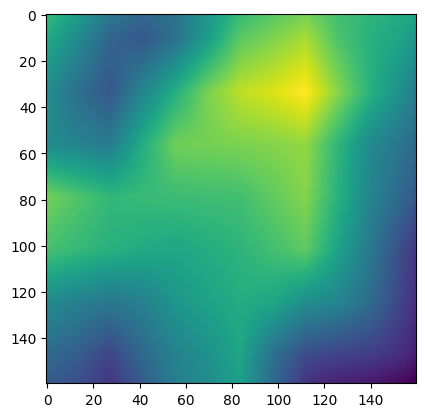

In [16]:
plt.imshow(t2m_total_RIGA[3,3,:,:])

In [17]:
# extract and save the data
np.save(f"{data_dir}/wind_u10_RIGA.npy", u10_total_RIGA)
np.save(f"{data_dir}/wind_u10_KTT.npy", u10_total_KTT)
np.save(f"{data_dir}/wind_u10_GTL.npy", u10_total_GTL)

np.save(f"{data_dir}/wind_v10_RIGA.npy", v10_total_RIGA)
np.save(f"{data_dir}/wind_v10_KTT.npy", v10_total_KTT)
np.save(f"{data_dir}/wind_v10_GTL.npy", v10_total_GTL)

np.save(f"{data_dir}/t2m_RIGA.npy", t2m_total_RIGA)
np.save(f"{data_dir}/t2m_KTT.npy", t2m_total_KTT)
np.save(f"{data_dir}/t2m_GTL.npy", t2m_total_GTL)

np.save(f"{data_dir}/tp_RIGA.npy", tp_total_RIGA)
np.save(f"{data_dir}/tp_KTT.npy", tp_total_KTT)
np.save(f"{data_dir}/tp_GTL.npy", tp_total_GTL)

np.save(f"{data_dir}/cdir_RIGA.npy", cdir_total_RIGA)
np.save(f"{data_dir}/cdir_KTT.npy", cdir_total_KTT)
np.save(f"{data_dir}/cdir_GTL.npy", cdir_total_GTL)

### Wind Data

The old an the new dataset have to be opened individually

In [ ]:
wind_data = xr.open_dataset(f"{wind_dir}/wind.nc") #, drop_variables='v10'
wind_data = wind_data.resample(time='1D').mean('time').compute()

In [ ]:
#wind_data = wind_data.sel(time=slice('2016-04-30', '2021-12-31'))
wind_data

<xarray.Dataset>
Dimensions:    (longitude: 85, latitude: 51, expver: 2, time: 60)
Coordinates:
  * longitude  (longitude) float32 9.25 9.5 9.75 10.0 ... 29.5 29.75 30.0 30.25
  * latitude   (latitude) float32 65.75 65.5 65.25 65.0 ... 53.75 53.5 53.25
  * expver     (expver) int32 5 1
  * time       (time) datetime64[ns] 2023-04-01 2023-04-02 ... 2023-05-30
Data variables:
    u10        (time, expver, latitude, longitude) float32 -5.224 -5.096 ... nan
    v10        (time, expver, latitude, longitude) float32 -5.43 -5.581 ... nan
    t2m        (time, expver, latitude, longitude) float32 277.0 276.9 ... nan
    cdir       (time, expver, latitude, longitude) float32 6.088e+05 ... nan
    tp         (time, expver, latitude, longitude) float32 8.496e-06 ... nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-12 07:33:14 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
# Resample the smaller dataset to match the dimensions of the larger dataset
wind_data = wind_data.sel(time=~wind_data.get_index("time").duplicated()).compute()
wind_data = wind_data.rename_dims({'longitude': 'x', 'latitude': 'y'}).rename_vars({"longitude": "x", "latitude": "y"}).set_coords(["x", "y"])

In [ ]:
time_length = wind_data.u10.shape[0]
print(time_length)

2072


In [ ]:
lat_lon_subset = chl_data[['x', 'y']]

u10_RIGA = np.empty((0,160,160))
u10_GTL = np.empty((0,160,160))
u10_KTT = np.empty((0,160,160))
v10_RIGA = np.empty((0,160,160))
v10_GTL = np.empty((0,160,160))
v10_KTT = np.empty((0,160,160))
for i in range(0,time_length,200):
  if i+200>time_length:
    wind_data1 = wind_data.isel(time=range(i,time_length,1))
  else:
    wind_data1 = wind_data.isel(time=range(i,i+200,1))
  wind_data_resampled = wind_data1.interp_like(lat_lon_subset, method='linear').compute()

  wind_data_RIGA = wind_data_resampled.isel(x=riga_range_x, y= riga_range_y)
  wind_data_u_RIGA = wind_data_RIGA['u10'].values
  u10_RIGA = np.append(u10_RIGA, wind_data_u_RIGA[:,:,:], axis=0)
  wind_data_v_RIGA = wind_data_RIGA['v10'].values
  v10_RIGA = np.append(v10_RIGA, wind_data_v_RIGA[:,:,:], axis=0)

  wind_data_KTT = wind_data_resampled.isel(x=kattegat_range_x, y= kattegat_range_y)
  wind_data_u_KTT = wind_data_KTT['u10'].values
  u10_KTT = np.append(u10_KTT, wind_data_u_KTT[:,:,:], axis=0)
  wind_data_v_KTT = wind_data_KTT['v10'].values
  v10_KTT = np.append(v10_KTT, wind_data_v_KTT[:,:,:], axis=0)

  wind_data_GTL = wind_data_resampled.isel(x=gotland_range_x, y= gotland_range_y)
  wind_data_u_GTL = wind_data_GTL['u10'].values
  u10_GTL = np.append(u10_GTL, wind_data_u_GTL[:,:,:], axis=0)
  wind_data_v_GTL = wind_data_GTL['v10'].values
  v10_GTL = np.append(v10_GTL, wind_data_v_GTL[:,:,:], axis=0)

print(u10_RIGA.shape)

(2072, 160, 160)


Newer dataset

In [ ]:
wind_data = xr.open_dataset(f"{wind_dir}/wind2.nc")
wind_data = wind_data.resample(time='1D').mean('time').compute()

In [ ]:
# Resample the smaller dataset to match the dimensions of the larger dataset
wind_data = wind_data.sel(time=~wind_data.get_index("time").duplicated()).compute()
wind_data = wind_data.rename_dims({'longitude': 'x', 'latitude': 'y'}).rename_vars({"longitude": "x", "latitude": "y"}).set_coords(["x", "y"])

In [ ]:
time_length = wind_data.u10.shape[0]
print(time_length)

488


In [ ]:
for i in range(time_length):
  wind_data1 = wind_data.isel(time=i)
  wind_data_resampled = wind_data1.interp_like(lat_lon_subset, method='linear').compute()

  wind_data_RIGA = wind_data_resampled.isel(x=riga_range_x, y= riga_range_y)
  wind_data_u_RIGA = wind_data_RIGA['u10'].values
  wind_data_v_RIGA = wind_data_RIGA['v10'].values


  wind_data_KTT = wind_data_resampled.isel(x=kattegat_range_x, y= kattegat_range_y)
  wind_data_u_KTT = wind_data_KTT['u10'].values
  wind_data_v_KTT = wind_data_KTT['v10'].values

  wind_data_GTL = wind_data_resampled.isel(x=gotland_range_x, y= gotland_range_y)
  wind_data_u_GTL = wind_data_GTL['u10'].values
  wind_data_v_GTL = wind_data_GTL['v10'].values

  if np.isnan(wind_data_u_RIGA[0,:,:]).all():
    u10_RIGA = np.append(u10_RIGA, wind_data_u_RIGA[1,np.newaxis,:,:], axis=0)
    v10_RIGA = np.append(v10_RIGA, wind_data_v_RIGA[1,np.newaxis,:,:], axis=0)
    u10_KTT = np.append(u10_KTT, wind_data_u_KTT[1,np.newaxis,:,:], axis=0)
    v10_KTT = np.append(v10_KTT, wind_data_v_KTT[1,np.newaxis,:,:], axis=0)
    u10_GTL = np.append(u10_GTL, wind_data_u_GTL[1,np.newaxis,:,:], axis=0)
    v10_GTL = np.append(v10_GTL, wind_data_v_GTL[1,np.newaxis,:,:], axis=0)
  else:
    u10_RIGA = np.append(u10_RIGA, wind_data_u_RIGA[0,np.newaxis,:,:], axis=0)
    v10_RIGA = np.append(v10_RIGA, wind_data_v_RIGA[0,np.newaxis,:,:], axis=0)
    u10_KTT = np.append(u10_KTT, wind_data_u_KTT[0,np.newaxis,:,:], axis=0)
    v10_KTT = np.append(v10_KTT, wind_data_v_KTT[0,np.newaxis,:,:], axis=0)
    u10_GTL = np.append(u10_GTL, wind_data_u_GTL[0,np.newaxis,:,:], axis=0)
    v10_GTL = np.append(v10_GTL, wind_data_v_GTL[0,np.newaxis,:,:], axis=0)
print(u10_RIGA.shape)

now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
now
(2560, 160, 160)


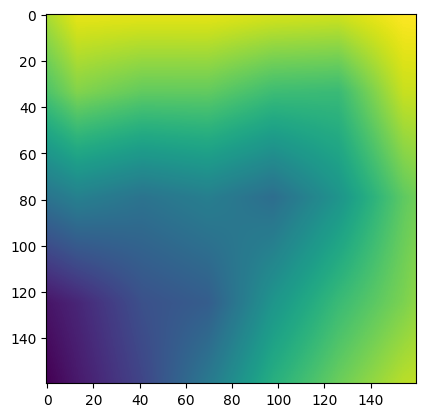

In [ ]:
plt.imshow(v10_RIGA[2500,:,:])

In [ ]:
# extract and save the data
plt.imshow(v10_RIGA[2500,:,:])
np.save(f"{data_dir_RIGA}/wind_u10.npy", u10_RIGA)
np.save(f"{data_dir_KTT}/wind_u10.npy", u10_KTT)
np.save(f"{data_dir_GTL}/wind_u10.npy", u10_GTL)

np.save(f"{data_dir_RIGA}/wind_v10.npy", v10_RIGA)
np.save(f"{data_dir_KTT}/wind_v10.npy", v10_KTT)
np.save(f"{data_dir_GTL}/wind_v10.npy", v10_GTL)

### Prescipitation

The older and the more recent dataset have to be opened individually

In [ ]:
pres_data = xr.open_dataset(f"{pres_dir}/pres.nc")
pres_data = pres_data.resample(time='1D').mean('time').compute()

<xarray.Dataset>
Dimensions:    (longitude: 85, latitude: 51, time: 2192)
Coordinates:
  * longitude  (longitude) float32 9.25 9.5 9.75 10.0 ... 29.5 29.75 30.0 30.25
  * latitude   (latitude) float32 65.75 65.5 65.25 65.0 ... 53.75 53.5 53.25
  * time       (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2021-12-31
Data variables:
    t2m        (time, latitude, longitude) float32 280.0 279.9 ... 273.2 273.1
    tp         (time, latitude, longitude) float32 2.649e-05 ... 0.0001955
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-02 20:13:21 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
pres_data = pres_data.sel(time=slice('2016-04-30', '2021-12-31'))

In [ ]:
# Rename dimensions
pres_data = pres_data.sel(time=~pres_data.get_index("time").duplicated())
pres_data = pres_data.rename_dims({'longitude': 'x', 'latitude': 'y'}).rename_vars({"longitude": "x", "latitude": "y"}).set_coords(["x", "y"])

In [ ]:
pres_data

<xarray.Dataset>
Dimensions:  (x: 85, y: 51, time: 2072)
Coordinates:
  * x        (x) float32 9.25 9.5 9.75 10.0 10.25 ... 29.5 29.75 30.0 30.25
  * y        (y) float32 65.75 65.5 65.25 65.0 64.75 ... 54.0 53.75 53.5 53.25
  * time     (time) datetime64[ns] 2016-04-30 2016-05-01 ... 2021-12-31
Data variables:
    t2m      (time, y, x) float32 280.9 280.9 280.9 281.0 ... 273.4 273.2 273.1
    tp       (time, y, x) float32 2.886e-05 3.01e-05 ... 0.0002136 0.0001955
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-02 20:13:21 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
time_length = pres_data.tp.shape[0]
print(time_length)

2072


In [ ]:
t2m_RIGA = np.empty((0,160,160))
tp_RIGA = np.empty((0,160,160))

t2m_KTT = np.empty((0,160,160))
tp_KTT = np.empty((0,160,160))

t2m_GTL = np.empty((0,160,160))
tp_GTL = np.empty((0,160,160))
for i in range(0,time_length,200):
  if i+200>time_length:
    pres_data1 = pres_data.isel(time=range(i,time_length,1))
  else:
    pres_data1 = pres_data.isel(time=range(i,i+200,1))
  pres_data_resampled = pres_data1.interp_like(lat_lon_subset, method='linear').compute()

  # RIGA
  pres_data_RIGA = pres_data_resampled.isel(x=riga_range_x, y= riga_range_y)
  pres_data_tp_RIGA = pres_data_RIGA['tp'].values
  pres_data_t2m_RIGA = pres_data_RIGA['t2m'].values
  tp_RIGA = np.append(tp_RIGA, pres_data_tp_RIGA[:,:,:], axis=0)
  t2m_RIGA = np.append(t2m_RIGA, pres_data_t2m_RIGA[:,:,:], axis=0)


  # KTT
  pres_data_KTT = pres_data_resampled.isel(x=kattegat_range_x, y= kattegat_range_y)
  pres_data_tp_KTT = pres_data_KTT['tp'].values
  pres_data_t2m_KTT = pres_data_KTT['t2m'].values
  tp_KTT= np.append(tp_KTT, pres_data_tp_KTT[:,:,:], axis=0)
  t2m_KTT = np.append(t2m_KTT, pres_data_t2m_KTT[:,:,:], axis=0)

  # GTL
  pres_data_GTL = pres_data_resampled.isel(x=gotland_range_x, y= gotland_range_y)
  pres_data_tp_GTL = pres_data_GTL['tp'].values
  pres_data_t2m_GTL = pres_data_GTL['t2m'].values
  tp_GTL= np.append(tp_GTL, pres_data_tp_GTL[:,:,:], axis=0)
  t2m_GTL = np.append(t2m_GTL, pres_data_t2m_GTL[:,:,:], axis=0)


print(tp_RIGA.shape)
print(t2m_RIGA.shape)
print(tp_KTT.shape)
print(t2m_KTT.shape)
print(tp_GTL.shape)
print(t2m_GTL.shape)

(2072, 160, 160)
(2072, 160, 160)
(2072, 160, 160)
(2072, 160, 160)
(2072, 160, 160)
(2072, 160, 160)


In [ ]:
pres_data = xr.open_dataset(f"{pres_dir}/pres_22_23.nc")
pres_data = pres_data.resample(time='1D').mean('time').compute()
pres_data

<xarray.Dataset>
Dimensions:    (longitude: 43, latitude: 26, expver: 2, time: 482)
Coordinates:
  * longitude  (longitude) float32 9.25 9.75 10.25 10.75 ... 29.25 29.75 30.25
  * latitude   (latitude) float32 65.75 65.25 64.75 64.25 ... 54.25 53.75 53.25
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2023-04-27
Data variables:
    t2m        (time, expver, latitude, longitude) float32 275.3 275.0 ... 281.2
    tp         (time, expver, latitude, longitude) float32 6.639e-05 ... 0.00...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-02 15:03:23 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
pres_data = pres_data.sel(time=~pres_data.get_index("time").duplicated())
pres_data = pres_data.rename_dims({'longitude': 'x', 'latitude': 'y'}).rename_vars({"longitude": "x", "latitude": "y"}).set_coords(["x", "y"])

In [ ]:
pres_data

<xarray.Dataset>
Dimensions:  (x: 43, y: 26, expver: 2, time: 482)
Coordinates:
  * x        (x) float32 9.25 9.75 10.25 10.75 11.25 ... 28.75 29.25 29.75 30.25
  * y        (y) float32 65.75 65.25 64.75 64.25 ... 54.75 54.25 53.75 53.25
  * expver   (expver) int32 1 5
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2023-04-27
Data variables:
    t2m      (time, expver, y, x) float32 275.3 275.0 274.8 ... 280.2 281.2
    tp       (time, expver, y, x) float32 6.639e-05 4.262e-05 ... 0.0004217
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-02 15:03:23 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
time_length = pres_data.tp.shape[0]
print(time_length)

482


In [ ]:
for i in range(0,time_length,1):
  pres_data1 = pres_data.isel(time=i)
  pres_data_resampled = pres_data1.interp_like(lat_lon_subset, method='linear').compute()

  # RIGA
  pres_data_RIGA = pres_data_resampled.isel(x=riga_range_x, y= riga_range_y)
  pres_data_tp_RIGA = pres_data_RIGA['tp'].values
  pres_data_t2m_RIGA = pres_data_RIGA['t2m'].values

  # KTT
  pres_data_KTT = pres_data_resampled.isel(x=kattegat_range_x, y= kattegat_range_y)
  pres_data_tp_KTT = pres_data_KTT['tp'].values
  pres_data_t2m_KTT = pres_data_KTT['t2m'].values

  # GTL
  pres_data_GTL = pres_data_resampled.isel(x=gotland_range_x, y= gotland_range_y)
  pres_data_tp_GTL = pres_data_GTL['tp'].values
  pres_data_t2m_GTL = pres_data_GTL['t2m'].values

  if np.isnan(pres_data_tp_RIGA[0,:,:]).all():
    tp_RIGA = np.append(tp_RIGA, pres_data_tp_RIGA[1,np.newaxis,:,:], axis=0)
    t2m_RIGA = np.append(t2m_RIGA, pres_data_t2m_RIGA[1,np.newaxis,:,:], axis=0)
    tp_KTT= np.append(tp_KTT, pres_data_tp_KTT[1,np.newaxis,:,:], axis=0)
    t2m_KTT = np.append(t2m_KTT, pres_data_t2m_KTT[1,np.newaxis,:,:], axis=0)
    tp_GTL= np.append(tp_GTL, pres_data_tp_GTL[1,np.newaxis,:,:], axis=0)
    t2m_GTL = np.append(t2m_GTL, pres_data_t2m_GTL[1,np.newaxis,:,:], axis=0)
  else:
    tp_RIGA = np.append(tp_RIGA, pres_data_tp_RIGA[0,np.newaxis,:,:], axis=0)
    t2m_RIGA = np.append(t2m_RIGA, pres_data_t2m_RIGA[0,np.newaxis,:,:], axis=0)
    tp_KTT= np.append(tp_KTT, pres_data_tp_KTT[0,np.newaxis,:,:], axis=0)
    t2m_KTT = np.append(t2m_KTT, pres_data_t2m_KTT[0,np.newaxis,:,:], axis=0)
    tp_GTL= np.append(tp_GTL, pres_data_tp_GTL[0,np.newaxis,:,:], axis=0)
    t2m_GTL = np.append(t2m_GTL, pres_data_t2m_GTL[0,np.newaxis,:,:], axis=0)


print(tp_RIGA.shape)
print(t2m_RIGA.shape)
print(tp_KTT.shape)
print(t2m_KTT.shape)
print(tp_GTL.shape)
print(t2m_GTL.shape)

(2554, 160, 160)
(2554, 160, 160)
(2554, 160, 160)
(2554, 160, 160)
(2554, 160, 160)
(2554, 160, 160)


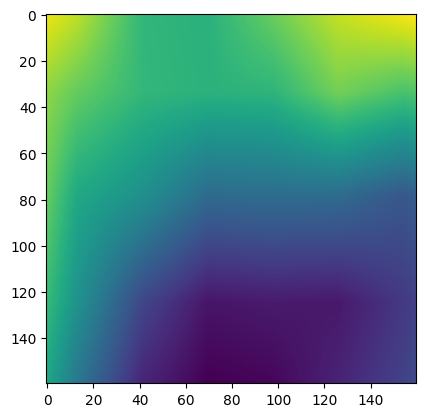

In [ ]:
plt.imshow(tp_RIGA[2500,:,:])

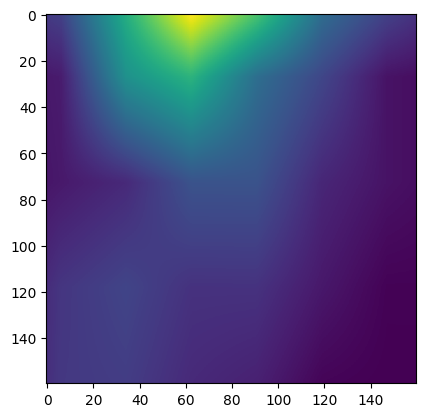

In [ ]:
plt.imshow(tp_KTT[2500,:,:])

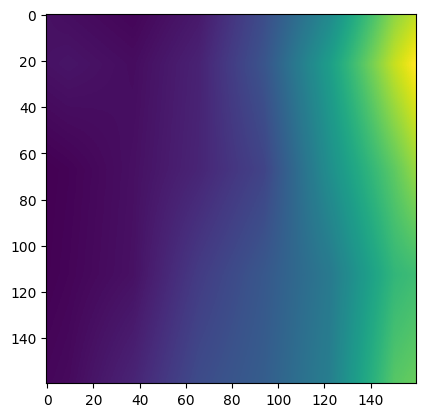

In [ ]:
plt.imshow(tp_GTL[2500,:,:])

In [ ]:
np.save(f'{data_dir_RIGA}/pres_tp.npy', tp_RIGA)
np.save(f'{data_dir_RIGA}/pres_t2m.npy', t2m_RIGA)
np.save(f'{data_dir_KTT}/pres_tp.npy', tp_KTT)
np.save(f'{data_dir_KTT}/pres_t2m.npy', t2m_KTT)
np.save(f'{data_dir_GTL}/pres_tp.npy', tp_GTL)
np.save(f'{data_dir_GTL}/pres_t2m.npy', t2m_GTL)

## Radiance

In [ ]:
pres_data = xr.open_dataset(f"{rad_dir}/radiation.nc")
pres_data = pres_data.resample(time='1D').mean('time').compute()
pres_data

<xarray.Dataset>
Dimensions:    (longitude: 43, latitude: 26, expver: 2, time: 2680)
Coordinates:
  * longitude  (longitude) float32 9.25 9.75 10.25 10.75 ... 29.25 29.75 30.25
  * latitude   (latitude) float32 65.75 65.25 64.75 64.25 ... 54.25 53.75 53.25
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2023-05-03
Data variables:
    cdir       (time, expver, latitude, longitude) float32 3.671e+03 ... 4.39...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-08 16:25:17 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
pres_data = pres_data.sel(time=slice('2016-05-01', '2023-04-14'))
# Rename dimensions
pres_data = pres_data.sel(time=~pres_data.get_index("time").duplicated())
pres_data = pres_data.rename_dims({'longitude': 'x', 'latitude': 'y'}).rename_vars({"longitude": "x", "latitude": "y"}).set_coords(["x", "y"])
pres_data

<xarray.Dataset>
Dimensions:  (x: 43, y: 26, expver: 2, time: 2540)
Coordinates:
  * x        (x) float32 9.25 9.75 10.25 10.75 11.25 ... 28.75 29.25 29.75 30.25
  * y        (y) float32 65.75 65.25 64.75 64.25 ... 54.75 54.25 53.75 53.25
  * expver   (expver) int32 1 5
  * time     (time) datetime64[ns] 2016-05-01 2016-05-02 ... 2023-04-14
Data variables:
    cdir     (time, expver, y, x) float32 3.55e+06 3.539e+06 ... 3.203e+06
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-08 16:25:17 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
time_length = pres_data.cdir.shape[0]
print(time_length)

2540


In [ ]:
lat_lon_subset = chl_data[['x', 'y']]

In [ ]:
rad_RIGA = np.empty((0,160,160))

rad_KTT = np.empty((0,160,160))

rad_GTL = np.empty((0,160,160))

In [ ]:
for i in range(0,time_length,1):
  pres_data1 = pres_data.isel(time=i)
  pres_data_resampled = pres_data1.interp_like(lat_lon_subset, method='linear').compute()

  # RIGA
  pres_data_RIGA = pres_data_resampled.isel(x=riga_range_x, y= riga_range_y)
  pres_data_tp_RIGA = pres_data_RIGA['cdir'].values

  # KTT
  pres_data_KTT = pres_data_resampled.isel(x=kattegat_range_x, y= kattegat_range_y)
  pres_data_tp_KTT = pres_data_KTT['cdir'].values

  # GTL
  pres_data_GTL = pres_data_resampled.isel(x=gotland_range_x, y= gotland_range_y)
  pres_data_tp_GTL = pres_data_GTL['cdir'].values

  if np.isnan(pres_data_tp_RIGA[0,:,:]).all():
    rad_RIGA = np.append(rad_RIGA, pres_data_tp_RIGA[1,np.newaxis,:,:], axis=0)
    rad_KTT= np.append(rad_KTT, pres_data_tp_KTT[1,np.newaxis,:,:], axis=0)
    rad_GTL= np.append(rad_GTL, pres_data_tp_GTL[1,np.newaxis,:,:], axis=0)
  else:
    rad_RIGA = np.append(rad_RIGA, pres_data_tp_RIGA[0,np.newaxis,:,:], axis=0)
    rad_KTT= np.append(rad_KTT, pres_data_tp_KTT[0,np.newaxis,:,:], axis=0)
    rad_GTL= np.append(rad_GTL, pres_data_tp_GTL[0,np.newaxis,:,:], axis=0)


print(rad_RIGA.shape)
print(rad_KTT.shape)
print(rad_GTL.shape)

(2540, 160, 160)
(2540, 160, 160)
(2540, 160, 160)


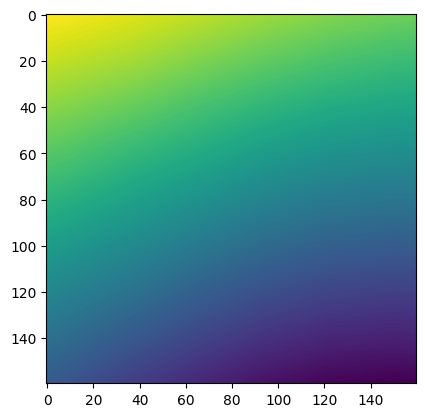

In [ ]:
plt.imshow(rad_GTL[2500,:,:])

In [ ]:
np.save(f'{data_dir_RIGA}/pres_rad.npy', rad_RIGA)
np.save(f'{data_dir_KTT}/pres_rad.npy', rad_KTT)
np.save(f'{data_dir_GTL}/pres_rad.npy', rad_GTL)